# Cardiovascular Deaths Regression Models and Analysis

---

**Importing Model Dependencies**

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# For QQ plot
from statsmodels.graphics.gofplots import qqplot


# To surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data

df = pd.read_csv(r"C:\Users\rave_consolidate\Desktop\cadiovascular_death\dataset\trainset.csv")
df_test = pd.read_csv(r"C:\Users\rave_consolidate\Desktop\cadiovascular_death\dataset\testset.csv")

In [3]:
df.head()

,year,code,temp_change,CO2,cardio_deaths
0,1991,AFG,0.000891,14436271.0,266.298725
1,1992,AFG,0.000891,13517736.0,224.447196
2,1993,AFG,0.000890,12913293.0,278.393699
3,1996,AFG,0.000888,16127630.0,315.446081
4,2004,AFG,0.000936,20214652.0,332.240918


In [4]:
df_test.head()

,year,code,temp_change,CO2
0,2022,ESP,4.248217e-06,306905.00
1,2022,ESP,5.498951e-07,55276.00
2,2022,ESP,5.412198e-05,4333367.00
3,2022,ESP,1.100690e-06,51516.69
4,2022,ESP,2.369140e-07,13152.00


In [5]:
df.columns

Index(['year', 'code', 'temp_change', 'CO2', 'cardio_deaths'], dtype='object')

In [6]:
# preprosses code as category

df.code = df.code.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   year           3431 non-null   int64   
 1   code           3431 non-null   category
 2   temp_change    3431 non-null   float64 
 3   CO2            3431 non-null   float64 
 4   cardio_deaths  3431 non-null   float64 
dtypes: category(1), float64(3), int64(1)
memory usage: 119.3 KB


In [24]:
# Function to calculate RMSE

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
# Function to plot predicted vs Actual

def plot_predicted_vs_actual(y_test, y_pred):
    """
    Plot Predicted vs Actual values.
    
    Parameters:
    y_test (array-like): True values
    y_pred (array-like): Predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()


In [26]:
def plot_qq(y_test, y_pred):
    """
    Create a QQ plot of residuals for model evaluation.
    
    Parameters:
    y_test (array-like): True values
    y_pred (array-like): Predicted values
    """
    residuals = y_test - y_pred
    sm.qqplot(residuals, line='45')
    plt.title('QQ Plot of Residuals')
    plt.show()

In [28]:
categorical_features = ['code'] # that is the country code

numerical_features = df.select_dtypes(exclude="category").drop("cardio_deaths", axis = 1).columns.tolist()
target = 'cardio_deaths'

# Split features and target
X = df[categorical_features + numerical_features]
y = df[target].values.reshape(-1, 1)

In [29]:
X.head()

,code,year,temp_change,CO2
0,AFG,1991,0.000891,14436271.0
1,AFG,1992,0.000891,13517736.0
2,AFG,1993,0.000890,12913293.0
3,AFG,1996,0.000888,16127630.0
4,AFG,2004,0.000936,20214652.0


In [33]:
y[:5]

array([[266.2987247],
       [224.4471964],
       [278.3936988],
       [315.4460807],
       [332.2409175]])

In [34]:
# spilt the data set using the train-test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Target Transformation

target_transformer = PowerTransformer(method='yeo-johnson')
y_train_transformed = target_transformer.fit_transform(y_train)
y_test_transformed = target_transformer.transform(y_test)

In [36]:
# Column transformer for preprocessing
preprocessor = ColumnTransformer(
        transformers=[
            ('num', PowerTransformer(method='yeo-johnson'), numerical_features),
            ('cat', CatBoostEncoder(), categorical_features)
        ])

In [37]:
# Full pipeline with preprocessor and model

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])

In [56]:
# Model Training
pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['year', 'temp_change',
                                                   'CO2']),
                                                 ('cat', CatBoostEncoder(),
                                                  ['code'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eva...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [66]:
# Model Evaluation

y_train_pred_transformed = pipeline.predict(X_train)
y_test_pred_transformed = pipeline.predict(X_test)

In [67]:
# Inverse transform predictions
y_train_pred = target_transformer.inverse_transform(y_train_pred_transformed.reshape(-1, 1))
y_test_pred = target_transformer.inverse_transform(y_test_pred_transformed.reshape(-1, 1))

In [68]:
# RMSE evaluation

print(rmse(y_train, y_train_pred))
print(rmse(y_test, y_test_pred))

30.844569600091038
36.34581173007366


In [69]:
# r2_scored evaluation

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

0.8546877182471366
0.8097472610853114


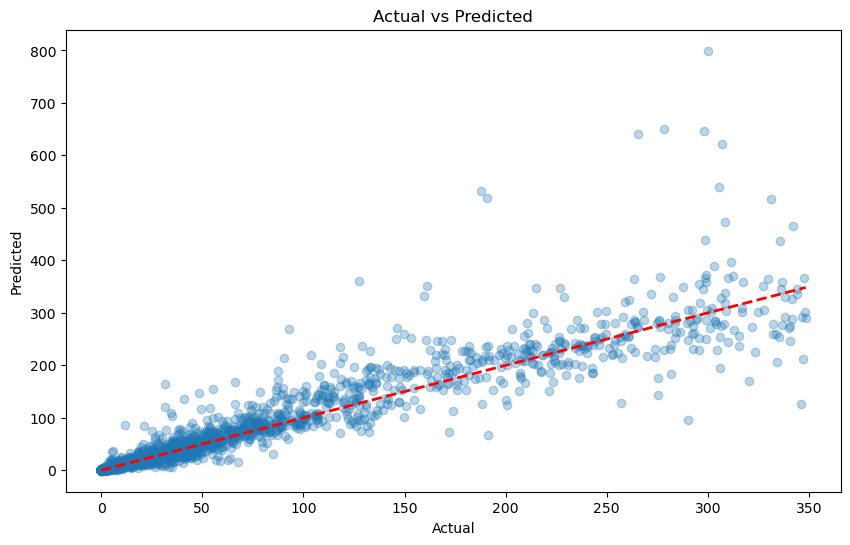

In [63]:
plot_predicted_vs_actual(y_train, y_train_pred)

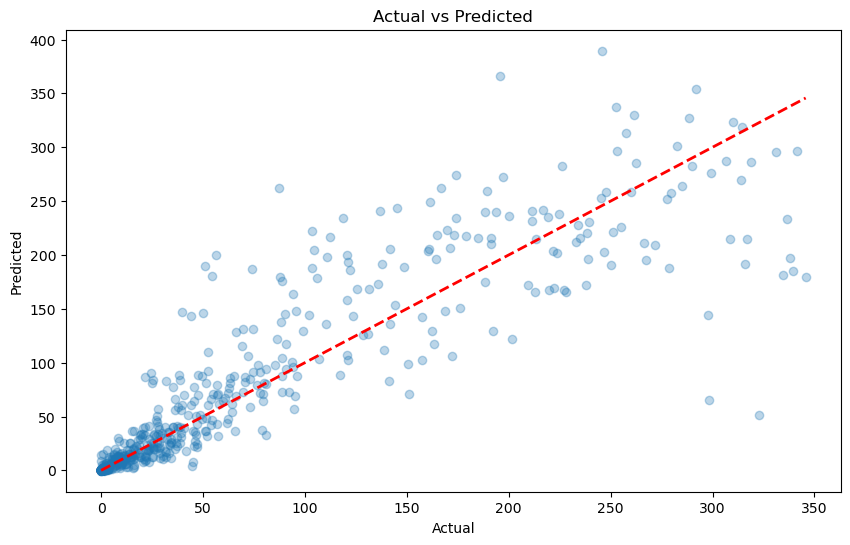

In [70]:
# plot predicted vs actuals

plot_predicted_vs_actual(y_test, y_test_pred)

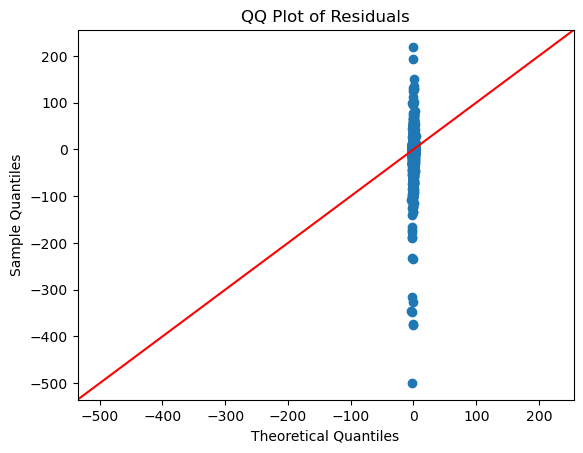

In [64]:
# plot the qqplot

plot_qq(y_train, y_train_pred)

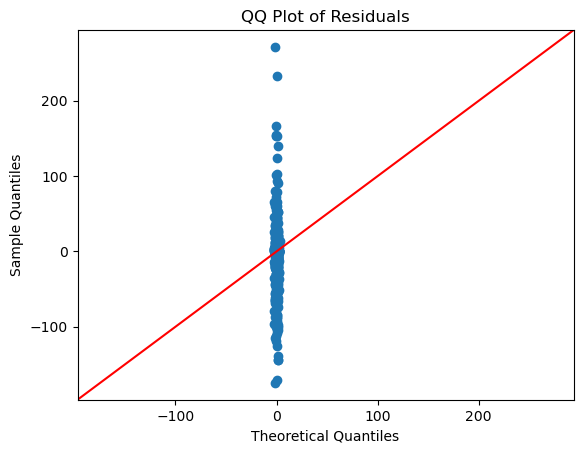

In [72]:
# plot qqplot for test data

plot_qq(y_test, y_test_pred)

In [73]:
# Define a custom RMSE scorer to handle inverse transformation of the predicted figures
def rmse_scorer(estimator, X, y):
    y_pred_transformed = estimator.predict(X)
    y_pred = target_transformer.inverse_transform(y_pred_transformed.reshape(-1, 1))
    return np.sqrt(mean_squared_error(y, y_pred))

In [77]:
# Create a KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for RMSE
cv_rmse_scores = cross_val_score(
    pipeline, X, y.ravel(), cv=kf, scoring=make_scorer(rmse_scorer)
)

# cross-validation for R²
cv_r2_scores = cross_val_score(
    pipeline, X, y.ravel(), cv=kf, scoring='r2'
)

# Print cross-validated scores
print(f'Cross-validated RMSE: {cv_rmse_scores.mean()} ± {cv_rmse_scores.std()}')
print(f'Cross-validated R²: {cv_r2_scores.mean()} ± {cv_r2_scores.std()}')

Cross-validated RMSE: nan ± nan
Cross-validated R²: 0.7591754939842625 ± 0.03404069991847028
